In [1]:
import os

# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_theme(context='paper', style='white', font_scale=1.6, color_codes=True)

In [50]:
import jax.numpy as jnp
import equinox as eqx
import optax

from functools import partial

from tensorflow_probability.substrates.jax.stats import expected_calibration_error as compute_ece
from jax import random as jr, nn, vmap, lax, jit
import jax.tree_util as jtu
from jax.scipy.linalg import solve
from jax.scipy.special import digamma

from bmr4pml.nn import LeNet, MlpMixer
from bmr4pml.nn.utils import PatchConvEmbed, PatchLinearEmbed
from bmr4pml.datasets import load_data

from blrax.optim import ivon
from blrax.utils import parallel_value_and_grad, get_scale, sample_posterior

rng_key = jr.PRNGKey(0)

In [66]:
def exact_blr(y, X, lam=1, mu_0=0., a_0=2., b_0=1.):
    # bayesian linear regression
    n, D = X.shape

    mu_0 = mu_0 * jnp.ones(D)
    P_0  = jnp.diag(lam * jnp.ones(D))
    S = X.T @ X
    P_n = P_0 + S
    mu_n = jnp.linalg.solve(P_n, X.T @ y + P_0 @ mu_0)

    a_n = a_0 + n/2
    b_n = b_0 + (y.T @ y + mu_0.T @ P_0 @ mu_0 - mu_n.T @ P_n @ mu_n)/2

    return mu_n, P_n, a_n, b_n

def vsolve(p, x):
    slv = partial(solve, assume_a="pos")
    return vmap(slv, in_axes=(None, 0))(p, x)

def nll(y, x, w, P, a, b):
    pi = a / b
    corr = vmap(vsolve, in_axes=(0, None))(P, x)
    corr = jnp.sum( corr * x, (-1, 0))
    return .5 * (jnp.sum(jnp.square(y - x @ w.mT), -1) + corr)
    
def bayes_l2_loss(X, y):
    _X = jnp.pad(X, [(0, 0), (0, 1)], constant_values=1.)
    params = vmap(exact_blr, in_axes=(0, None))(y.mT, lax.stop_gradient(_X))
    return nll(y, _X, *params), params

In [42]:
def del_f(mu, scale, prior_scale=1.):
    return (jnp.log(prior_scale) - jnp.log(scale)) - .5 * jnp.square(mu / scale)

def run_training(key, nnet, optim, train_ds, test_ds, num_epochs=10, batch_size=128, start_pruning=10):
    """
    Train a neural network using Equinox and Optax.
    
    Args:
        key: JAX PRNG key
        nnet: Equinox neural network
        optim: Optax (or blrax) optimizer
        train_ds: Training dataset dictionary with 'image' and 'label' keys
        test_ds: Test dataset dictionary with 'image' and 'label' keys
        num_epochs: Number of epochs to train
        batch_size: Batch size for training
    """
    
    # Initialize optimizer state
    params, static = eqx.partition(nnet, eqx.is_array)
    mask = jtu.tree_map(lambda x: jnp.ones_like(x, jnp.bool), params) 
    opt_state = optim.init(params)
    n_samples = len(train_ds['image'])
    img_shape = train_ds['image'].shape[-3:]
    steps_per_epoch = n_samples // batch_size
    
    # Cross entropy loss function
    def loss_fn(params, x, y, key=None):
        model = eqx.combine(params, static)
        logits = vmap(partial(model, key=key))(x)
        return optax.l2_loss(logits, y).sum(-1).mean()
    
    # Training step function
    @eqx.filter_jit
    def train_step(loss_fn, params, opt_state, x, y, mask, key):
        loss_value, grads = parallel_value_and_grad(loss_fn, opt_state[0], params, x, y, key, mask=mask)
        updates, opt_state = optim.update(grads, opt_state, params)
        updates = jtu.tree_map(lambda g, m: g * m, updates, mask)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    # Evaluation function
    @eqx.filter_jit
    def evaluate(params, images, labels):
        def evnet(params):
            model = eqx.nn.inference_mode(eqx.combine(params, static))
            return vmap(model)(images)
        
        logits = evnet(params)
            
        predictions = jnp.argmax(logits, axis=1)
        acc = jnp.mean(predictions == labels.argmax(-1))
        nll = optax.l2_loss(logits, labels).mean()
        ece = compute_ece(20, logits=logits, labels_true=labels.argmax(-1), labels_predicted=predictions)
        return acc, nll, ece
    
    # Inner training loop (one epoch)
    def train_epoch(carry, xs):
        params, mask, opt_state = carry
        key, epoch = xs
        
        # Shuffle training data
        key, _key = jr.split(key)
        perm = jr.permutation(_key, n_samples)
        train_images = train_ds['image'][perm]
        train_labels = train_ds['label'][perm]
        
        def train_step_scan(carry, xs):
            params, opt_state, key = carry
            
            batch_images, batch_labels = xs
            key, _key = jr.split(key)
            params, opt_state, loss_value = train_step(
                loss_fn, params, opt_state, batch_images, batch_labels, mask, _key
            )
            return (params, opt_state, key), loss_value
        
        # Run training steps for one epoch
        data = (
            train_images[:steps_per_epoch * batch_size].reshape(steps_per_epoch, batch_size, *img_shape),
            train_labels[:steps_per_epoch * batch_size].reshape(steps_per_epoch, batch_size, -1)
        )
        init_carry = (params, opt_state, key)
        (params, opt_state, key), losses = lax.scan(
            train_step_scan,
            init_carry,
            data
        )

        start = epoch > start_pruning
        select = partial(jnp.where, start)

        if hasattr(opt_state[0], "sample_params"):
            sigma = get_scale(opt_state[0])
            mask = jtu.tree_map(lambda m, s, t: select(t * (del_f(m, s) <= 0), t), params, sigma, mask)
            pruned_fraction = jtu.tree_map( lambda m: jnp.mean(~m), mask)
            _params = jtu.tree_map(lambda m, t: t * m, params, mask)
        else:
            pruned_fraction = 0.
            _params = params
        
        # Calculate metrics
        key, _key = jr.split(key)
        acc, nll, ece = evaluate(
            params,
            test_ds['image'],
            test_ds['label'],
        )
        
        metrics = {
            'loss': losses.sum() / steps_per_epoch,
            'acc': acc,
            'ece': ece,
            'nll': nll,
            'pf': pruned_fraction
        }
        
        return (_params, mask, opt_state), metrics
    
    # Run training for multiple epochs
    keys = jr.split(key, num_epochs)
    init_carry = (params, mask, opt_state)
    (params, mask, final_opt_state), metrics = lax.scan(
        train_epoch,
        init_carry,
        (keys, jnp.arange(num_epochs))
    )
    trained_model = eqx.combine(params, static)
    return trained_model, final_opt_state, metrics

def run_btraining(key, nnet, optim, train_ds, test_ds, num_epochs=10, batch_size=128, start_pruning=10):
    """
    Train a neural network using Equinox and Optax.
    
    Args:
        key: JAX PRNG key
        nnet: Equinox neural network
        optim: Optax (or blrax) optimizer
        train_ds: Training dataset dictionary with 'image' and 'label' keys
        test_ds: Test dataset dictionary with 'image' and 'label' keys
        num_epochs: Number of epochs to train
        batch_size: Batch size for training
    """
    
    # Initialize optimizer state
    params, static = eqx.partition(nnet, eqx.is_array)
    mask = jtu.tree_map(lambda x: jnp.ones_like(x, jnp.bool), params) 
    opt_state = optim.init(params)
    n_samples = len(train_ds['image'])
    img_shape = train_ds['image'].shape[-3:]
    steps_per_epoch = n_samples // batch_size
    
    # Cross entropy loss function
    def loss_fn(params, x, y, key=None, return_params=False):
        model = eqx.combine(params, static)
        out = vmap(partial(model, key=key))(x)
        loss, last_params = bayes_l2_loss(out, y)
        if return_params:
            return last_params
        else:
            return loss.mean()
    
    # Training step function
    @eqx.filter_jit
    def train_step(loss_fn, params, opt_state, x, y, mask, key):
        loss_value, grads = parallel_value_and_grad(loss_fn, opt_state[0], params, x, y, key, mask=mask)
        updates, opt_state = optim.update(grads, opt_state, params)
        updates = jtu.tree_map(lambda g, m: g * m, updates, mask)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    # Evaluation function
    @eqx.filter_jit
    def evaluate(params, last_layer, images, labels):
        def evnet(params):
            model = eqx.nn.inference_mode(eqx.combine(params, static))
            return vmap(model)(images)
        
        out = jnp.pad(evnet(params), [(0, 0), (0, 1)], constant_values=1.)
        pred = out @ last_layer[0].mT
            
        pred_label = jnp.argmax(pred, axis=1)
        acc = jnp.mean(pred_label == labels.argmax(-1))
        _nll = nll(labels, out, *last_layer).mean()
        ece = compute_ece(20, logits=pred, labels_true=labels.argmax(-1), labels_predicted=pred_label)
        return acc, _nll, ece
    
    # Inner training loop (one epoch)
    def train_epoch(carry, xs):
        params, mask, opt_state = carry
        key, epoch = xs
        
        # Shuffle training data
        key, _key = jr.split(key)
        perm = jr.permutation(_key, n_samples)
        train_images = train_ds['image'][perm]
        train_labels = train_ds['label'][perm]
        
        def train_step_scan(carry, xs):
            params, opt_state, key = carry
            
            batch_images, batch_labels = xs
            key, _key = jr.split(key)
            params, opt_state, loss_value = train_step(
                loss_fn, params, opt_state, batch_images, batch_labels, mask, _key
            )
            return (params, opt_state, key), loss_value
        
        # Run training steps for one epoch
        data = (
            train_images[:steps_per_epoch * batch_size].reshape(steps_per_epoch, batch_size, *img_shape),
            train_labels[:steps_per_epoch * batch_size].reshape(steps_per_epoch, batch_size, -1)
        )
        init_carry = (params, opt_state, key)
        (params, opt_state, key), losses = lax.scan(
            train_step_scan,
            init_carry,
            data
        )

        last_layer = loss_fn(params, train_images, train_labels, key=key, return_params=True)
        
        # Calculate metrics
        acc, nll, ece = evaluate(
            params,
            last_layer,
            test_ds['image'],
            test_ds['label'],
        )
        
        metrics = {
            'loss': losses.sum() / steps_per_epoch,
            'acc': acc,
            'ece': ece,
            'nll': nll,
        }
        
        return (params, mask, opt_state), metrics
    
    # Run training for multiple epochs
    keys = jr.split(key, num_epochs)
    init_carry = (params, mask, opt_state)
    (params, mask, final_opt_state), metrics = lax.scan(
        train_epoch,
        init_carry,
        (keys, jnp.arange(num_epochs))
    )
    trained_model = eqx.combine(params, static)
    return trained_model, final_opt_state, metrics

In [43]:
def standardize(train_images, test_images, num_channels=1):
    mean = train_images.reshape(-1, num_channels).mean(0)
    std = train_images.reshape(-1, num_channels).std(0)

    return (train_images - mean) / std, (test_images - mean) / std

def plot_performance(results, num_epochs):
    fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True)

    for key in results:
        vals = results[key]
        if vals is not None:
            for ax, lbl in zip(axes, ['acc', 'ece', 'nll']):
                ax.plot(range(1, num_epochs + 1), vals[lbl], 'o:', label=key)
                ax.set_xlabel('epoch')
                ax.set_title(lbl)

    axes[0].legend(title='method', fontsize=12)
    axes[0].set_ylim([.7, 1.])
    fig.tight_layout()

    return fig

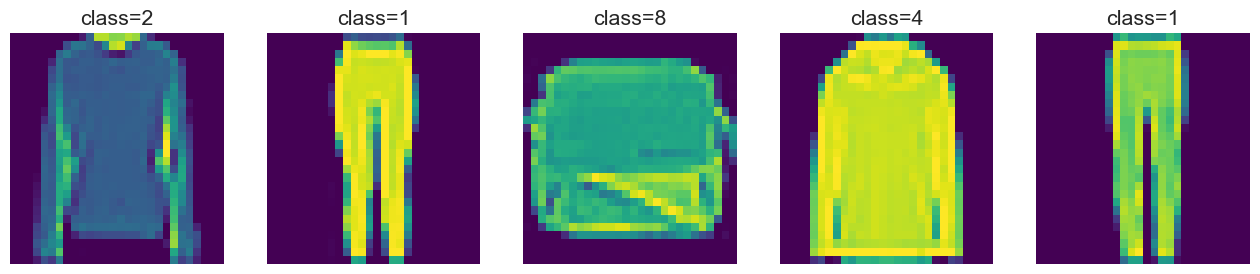

In [44]:
# load data
train_ds, test_ds = load_data('fashion_mnist', platform='gpu', id=0)

in_size = train_ds['image'].shape[-3:]
out_size = len(jnp.unique(train_ds['label']))

fig, axes = plt.subplots(1, 5, figsize=(16, 3), sharex=True, sharey=True)
for n in range(5):
    sns.heatmap(
        train_ds['image'][n].squeeze() / 255, 
        cmap='viridis', 
        ax = axes[n], 
        cbar=False, 
        vmax=1., 
        vmin=0.,
        xticklabels="",
        yticklabels=""
    )
    axes[n].set_title('class={}'.format(train_ds['label'][n]))

train_ds['image'], test_ds['image'] = standardize(train_ds['image'], test_ds['image'], num_channels=1)
train_ds['label'] = nn.one_hot(train_ds['label'], 10)
test_ds['label'] = nn.one_hot(test_ds['label'], 10)

# LeNet

In [46]:
train_ds['image'] = jnp.pad(train_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))
test_ds['image'] = jnp.pad(test_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))

in_size = train_ds['image'].shape[-3:]

print(in_size)

(1, 32, 32)


In [67]:
rng_key, key = jr.split(rng_key)
lenet = LeNet(in_size, activation=nn.tanh, dropout_rate=0.0, key=key)
blenet = LeNet(in_size, dense_features=[84], activation=nn.tanh, final_activation=nn.tanh, dropout_rate=0.0, key=key)

x = vmap(blenet)(train_ds['image'])
print(x.shape)

loss, params = bayes_l2_loss(x, train_ds['label'])
print(loss.mean())

(60000, 84)
0.21082118


In [82]:
batch_size = 2046
num_epochs = 200

optimizer1 = optax.adamw(1e-3)
optimizer2 = optax.adabelief(1e-3)
rng_key, key = jr.split(rng_key)
optimizer3 = ivon(
    key,
    1e-3,
    s0=10,
    h0=1e3 / batch_size,
    num_data=batch_size,
    mc_samples=4
)


tds = {'image': train_ds['image'][:batch_size], 
       'label': train_ds['label'][:batch_size]}

In [83]:
results = []

for optim in [optimizer1, optimizer2]:
    rng_key, key = jr.split(rng_key)
    trained_lenet, _, metrics = run_training(
        key,
        lenet, 
        optim, 
        tds, 
        test_ds, 
        num_epochs=num_epochs, 
        batch_size=batch_size
    )

    results.append(metrics)

In [84]:
for optim in [optimizer3]:
    rng_key, key = jr.split(rng_key)
    trained_lenet, final_opt_state, metrics = run_training(
        key,
        eqx.nn.inference_mode(lenet), 
        optim, 
        tds, 
        test_ds, 
        num_epochs=num_epochs, 
        batch_size=batch_size,
        start_pruning=num_epochs
    )
        
    results.append(metrics)

In [68]:
results_bayes = []

for optim in [optimizer1, optimizer2]:
    rng_key, key = jr.split(rng_key)
    trained_blenet, _, metrics = run_btraining(
        key,
        blenet, 
        optim, 
        tds, 
        test_ds, 
        num_epochs=num_epochs, 
        batch_size=batch_size
    )

    results_bayes.append(metrics)

In [69]:
for optim in [optimizer3]:
    rng_key, key = jr.split(rng_key)
    _, _, metrics = run_btraining(
        key,
        eqx.nn.inference_mode(blenet), 
        optim, 
        tds, 
        test_ds, 
        num_epochs=num_epochs, 
        batch_size=batch_size,
        start_pruning=num_epochs
    )
        
    results_bayes.append(metrics)

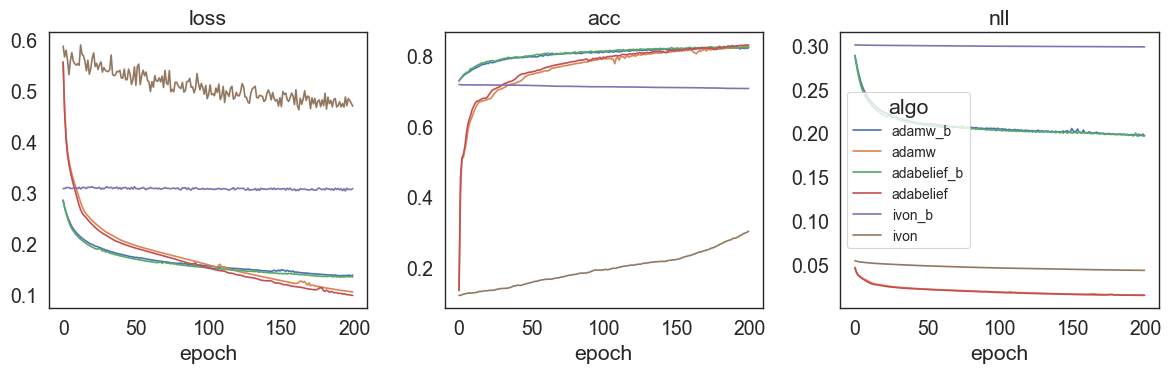

In [85]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, name in enumerate(['loss', 'acc', 'nll']):
    for j, algo in enumerate(["adamw", "adabelief", 'ivon']):
        axes[i].plot(results_bayes[j][name], label=algo + "_b")
        axes[i].plot(results[j][name], label=algo)

    axes[i].set_title(name)
    axes[i].set_xlabel('epoch')

plt.legend(title='algo', fontsize=10)
fig.tight_layout()

In [15]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

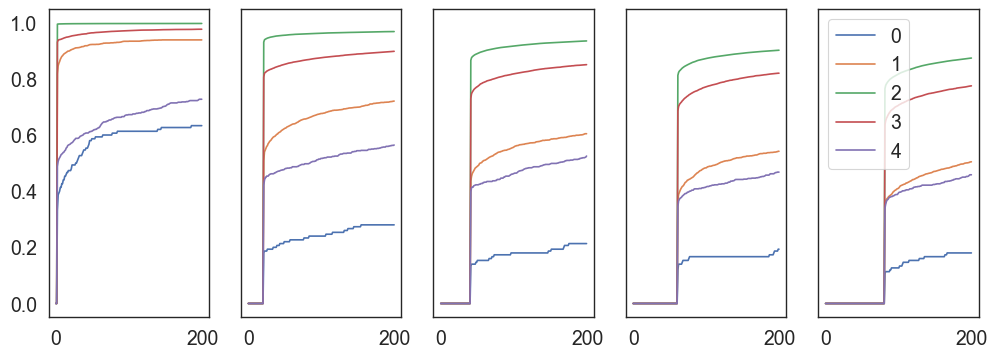

In [ ]:
batch_size = 128
num_epochs = 200
mus_prune = []
sigmas_prune = []
results_prune = []

fig, axes = plt.subplots(1, 5, figsize=(12, 4), sharex=True, sharey=True)
for n, start_pruning in enumerate([1, 20, 40, 60, 80]):
    for optim in [optimizer3]:
        rng_key, key = jr.split(rng_key)
        trained_lenet, final_opt_state, metrics = run_training(
            key,
            eqx.nn.inference_mode(lenet), 
            optim, 
            train_ds, 
            test_ds, 
            num_epochs=num_epochs, 
            batch_size=batch_size,
            start_pruning=start_pruning
        )

        state = final_opt_state[0]
        params = eqx.filter(trained_lenet, eqx.is_array)
        # mask = jtu.tree_map(lambda x: True, params)
            
        mus_prune.append(params)
        results_prune.append(metrics)

    for i, l in enumerate(results_prune[n]["pf"].layers):
        axes[n].plot(l.weight, label=i)

plt.legend()

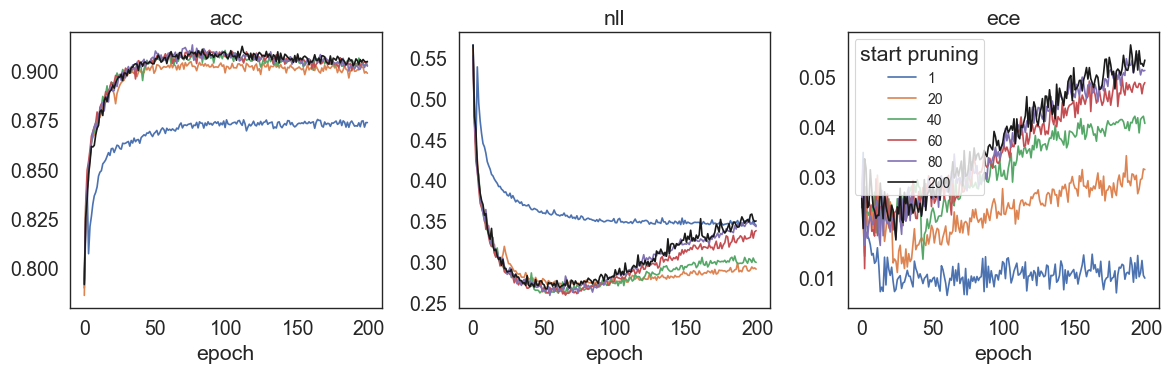

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, name in enumerate(['acc', 'nll', 'ece']):
    for j, sp in enumerate([1, 20, 40, 60, 80]):
        axes[i].plot(results_prune[j][name], label=sp)
    
    axes[i].plot(results[-1][name], 'k', label=200)
    axes[i].set_title(name)
    axes[i].set_xlabel('epoch')

plt.legend(title='start pruning', fontsize=10)
fig.tight_layout()

In [ ]:
break

# CIFAR10

(3, 36, 36) 10


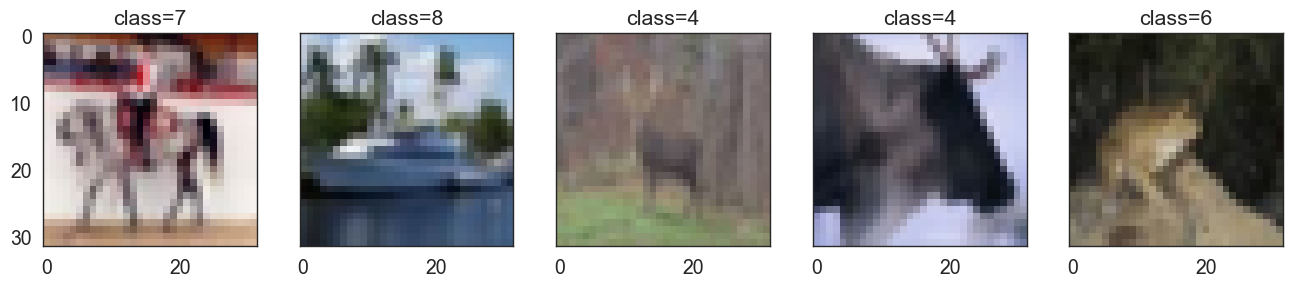

In [47]:
# load data
cif10_train_ds, cif10_test_ds = load_data('cifar10', platform='gpu', id=0)

fig, axes = plt.subplots(1, 5, figsize=(16, 3), sharex=True, sharey=True)
for n in range(5):
    axes[n].imshow(cif10_train_ds['image'][n]/255)
    axes[n].set_title('class={}'.format(cif10_train_ds['label'][n]))

cif10_train_ds['image'], cif10_test_ds['image'] = standardize(cif10_train_ds['image'], cif10_test_ds['image'], num_channels=3)

cif10_train_ds['image'] = jnp.pad(cif10_train_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))
cif10_test_ds['image'] = jnp.pad(cif10_test_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))

in_size_cif10 = cif10_train_ds['image'].shape[-3:]
out_size_cif10 = len(jnp.unique(cif10_train_ds['label']))

print(in_size_cif10, out_size_cif10)

rng_key, key = jr.split(rng_key)
mixer = MlpMixer(
    img_size=in_size_cif10[1],
    in_channels=in_size_cif10[0], 
    patch_size=4,
    embed_dim=128,
    tokens_hidden_dim=64,
    hidden_dim_ratio=8,
    num_blocks=8,
    num_classes=out_size_cif10,
    activation=nn.gelu,
    patch_embed=PatchConvEmbed,
    key=key
)

optimizer1 = optax.adamw(1e-3)
optimizer2 = optax.adabelief(1e-3)
rng_key, key = jr.split(rng_key)
optimizer3 = ivon(
    key,
    1e-3,
    s0=1.,
    h0=0.0125,
    num_data=len(cif10_train_ds['image']),
)

In [48]:
batch_size = 128
num_epochs = 200

results_cif10 = []

for optim in [optimizer1, optimizer2]:
    rng_key, key = jr.split(rng_key)
    _, final_opt_state, metrics = run_training(
        key,
        mixer, 
        optim, 
        cif10_train_ds, 
        cif10_test_ds, 
        num_epochs=num_epochs, 
        batch_size=batch_size
    )

    results_cif10.append(metrics)

In [51]:
for optim in [optimizer3]:
    rng_key, key = jr.split(rng_key)
    _, _, metrics = run_training(
        key,
        mixer, 
        optim, 
        cif10_train_ds, 
        cif10_test_ds, 
        num_epochs=num_epochs, 
        batch_size=batch_size,
        start_pruning=num_epochs
    )
    
    results_cif10.append(metrics)

2025-01-16 13:44:06.451904: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 14.11GiB (15150912004 bytes) by rematerialization; only reduced to 15.47GiB (16606869747 bytes), down from 15.47GiB (16615309851 bytes) originally


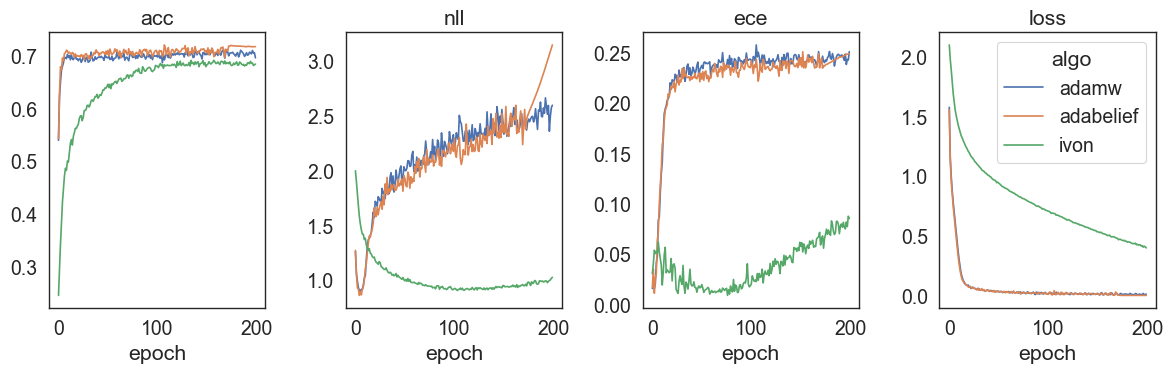

In [52]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

for i, name in enumerate(['acc', 'nll', 'ece', 'loss']):
    for j, algo in enumerate(["adamw", "adabelief", "ivon"]):
        axes[i].plot(results_cif10[j][name], label=algo)

    axes[i].set_title(name)
    axes[i].set_xlabel('epoch')

plt.legend(title='algo')
fig.tight_layout()

In [ ]:
batch_size = 128
num_epochs = 100
mus_prune_cif10 = []
results_prune_cif10 = []

for n, start_pruning in enumerate([1, 20, 40, 60, 80]):
    for optim in [optimizer3]:
        rng_key, key = jr.split(rng_key)
        trained_mixer, _, metrics = run_training(
            key,
            mixer, 
            optim, 
            cif10_train_ds, 
            cif10_test_ds, 
            num_epochs=num_epochs, 
            batch_size=batch_size,
            start_pruning=start_pruning
        )

        state = final_opt_state[0]
        params = eqx.filter(trained_mixer, eqx.is_array)
            
        mus_prune_cif10.append(params)
        results_prune_cif10.append(metrics)

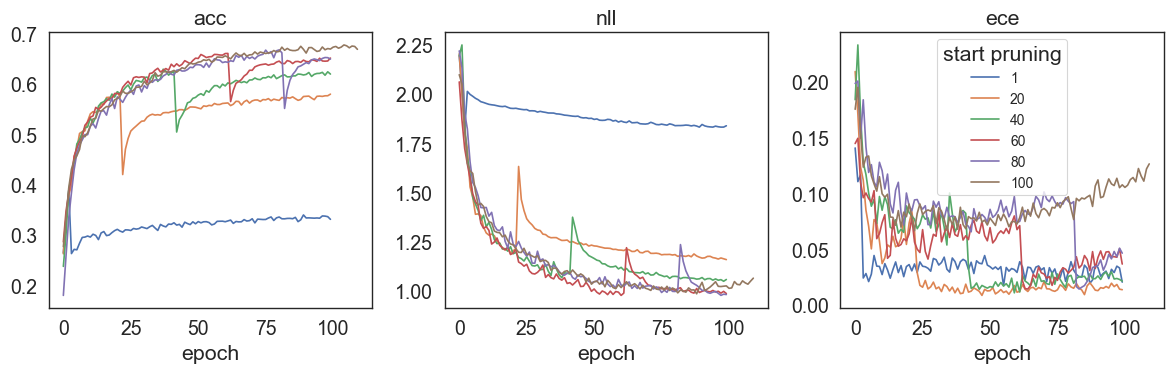

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, name in enumerate(['acc', 'nll', 'ece']):
    for j, sp in enumerate([1, 20, 40, 60, 80]):
        axes[i].plot(results_prune_cif10[j][name], label=sp)

    axes[i].plot(results_cif10[-1][name][:110], label=100)
    axes[i].set_title(name)
    axes[i].set_xlabel('epoch')

plt.legend(title='start pruning', fontsize=10)
fig.tight_layout()

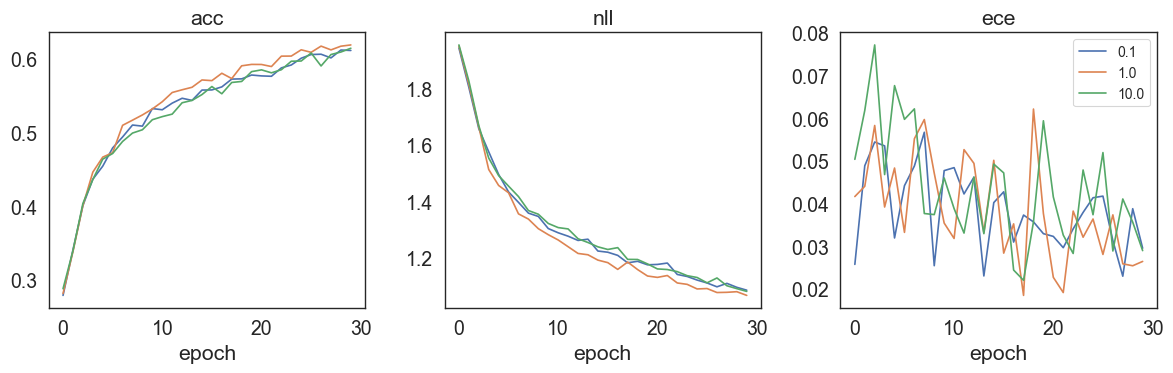

In [45]:
rng_key, key = jr.split(rng_key)
vals = [.1, 1., 10.]
num_epochs = 30
results_test = []

for v in vals:
    optimizer3 = ivon(
        key,
        1e-3,
        s0=v,
        h0=0.0125,
        num_data=len(cif10_train_ds['image']),
    )

    for optim in [optimizer3]:
        rng_key, key = jr.split(rng_key)
        _, _, metrics = run_training(
            key,
            mixer, 
            optim, 
            cif10_train_ds, 
            cif10_test_ds, 
            num_epochs=num_epochs, 
            batch_size=batch_size,
            start_pruning=100
        )
        
        results_test.append(metrics)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, name in enumerate(['acc', 'nll', 'ece']):
    for j, sp in enumerate(vals):
        axes[i].plot(results_test[j][name], label=sp)

    # axes[i].plot(results_cif10[-1][name][:20], label=4)
    axes[i].set_title(name)
    axes[i].set_xlabel('epoch')

plt.legend(fontsize=10)
fig.tight_layout()

# CIFAR100

(3, 36, 36) 100


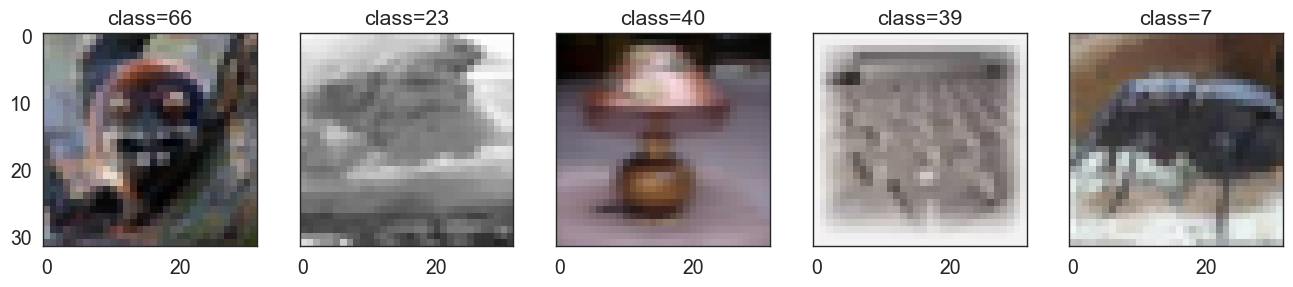

In [12]:
# load data
cif100_train_ds, cif100_test_ds = load_data('cifar100', platform='gpu', id=0)

in_size_cif100 = cif100_train_ds['image'].shape[-3:]
out_size_cif100 = len(jnp.unique(cif100_train_ds['label']))

fig, axes = plt.subplots(1, 5, figsize=(16, 3), sharex=True, sharey=True)
for n in range(5):
    axes[n].imshow(cif100_train_ds['image'][n]/255)
    axes[n].set_title('class={}'.format(cif100_train_ds['label'][n]))

cif100_train_ds['image'], cif100_test_ds['image'] = standardize(cif100_train_ds['image'], cif100_test_ds['image'], num_channels=3)

cif100_train_ds['image'] = jnp.pad(cif100_train_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))
cif100_test_ds['image'] = jnp.pad(cif100_test_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))

in_size_cif100 = cif100_train_ds['image'].shape[-3:]
out_size_cif100 = len(jnp.unique(cif100_train_ds['label']))

print(in_size_cif100, out_size_cif100)

rng_key, key = jr.split(rng_key)
mixer = MlpMixer(
    img_size=in_size_cif100[1],
    in_channels=in_size_cif100[0], 
    patch_size=4,
    embed_dim=128,
    tokens_hidden_dim=64,
    hidden_dim_ratio=8,
    num_blocks=8,
    num_classes=out_size_cif100,
    activation=nn.gelu,
    patch_embed=PatchConvEmbed,
    key=key
)

lr_schd = optax.schedules.warmup_cosine_decay_schedule(
    1e-1 / 25,
    1e-1,
    40000 // 4,
    40000,
    1e-5
)

optimizer1 = optax.adamw(lr_schd)
optimizer2 = optax.adabelief(lr_schd)
rng_key, key = jr.split(rng_key)
optimizer3 = ivon(
    key,
    lr_schd,
    s0=1e2,
    h0=5e-1,
    num_data=len(cif100_train_ds['image']),
)

batch_size = 128
num_epochs = 100

In [7]:
results_cif100 = []

for optim in [optimizer1, optimizer2]:
    rng_key, key = jr.split(rng_key)
    _, _, metrics = run_training(
        key,
        mixer, 
        optim, 
        cif100_train_ds, 
        cif100_test_ds, 
        num_epochs=num_epochs, 
        batch_size=batch_size
    )

    results_cif100.append(metrics)

In [ ]:
for optim in [optimizer3]:
    rng_key, key = jr.split(rng_key)
    _, _, metrics = run_training(
        key,
        mixer, 
        optim, 
        cif100_train_ds, 
        cif100_test_ds, 
        num_epochs=num_epochs, 
        batch_size=batch_size,
        start_pruning=num_epochs
    )
    
    results_cif100.append(metrics)

2025-01-17 13:22:06.307388: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 14.11GiB (15150578406 bytes) by rematerialization; only reduced to 15.47GiB (16607024745 bytes), down from 15.47GiB (16615464849 bytes) originally


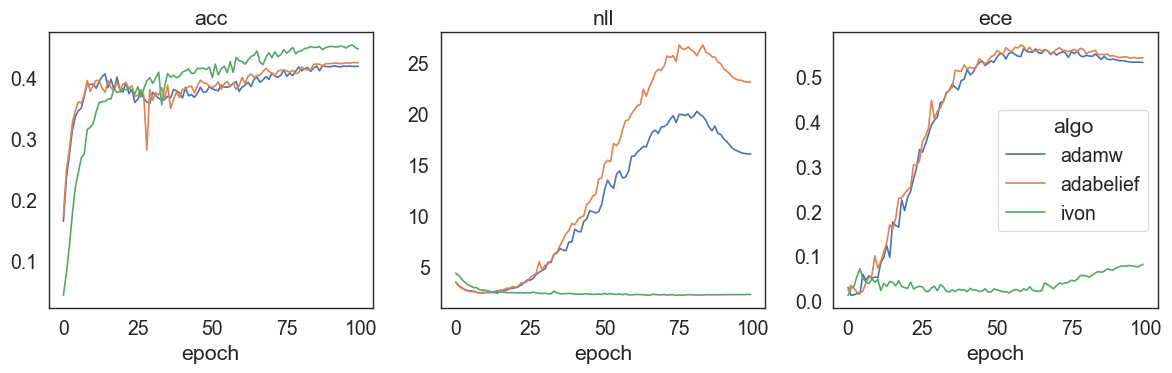

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, name in enumerate(['acc', 'nll', 'ece']):
    for j, algo in enumerate(["adamw", "adabelief", "ivon"]):
        axes[i].plot(results_cif100[j][name], label=algo)

    axes[i].set_title(name)
    axes[i].set_xlabel('epoch')

plt.legend(title='algo')
fig.tight_layout()

In [48]:
batch_size = 128
num_epochs = 120
mus_prune_cif100 = []
results_prune_cif100 = []

for n, start_pruning in enumerate([1, 20, 40, 60, 80]):
    for optim in [optimizer3]:
        rng_key, key = jr.split(rng_key)
        trained_mixer, _, metrics = run_training(
            key,
            mixer, 
            optim, 
            cif100_train_ds, 
            cif100_test_ds, 
            num_epochs=num_epochs, 
            batch_size=batch_size,
            start_pruning=start_pruning
        )

        params = eqx.filter(trained_mixer, eqx.is_array)
            
        mus_prune_cif100.append(params)
        results_prune_cif100.append(metrics)

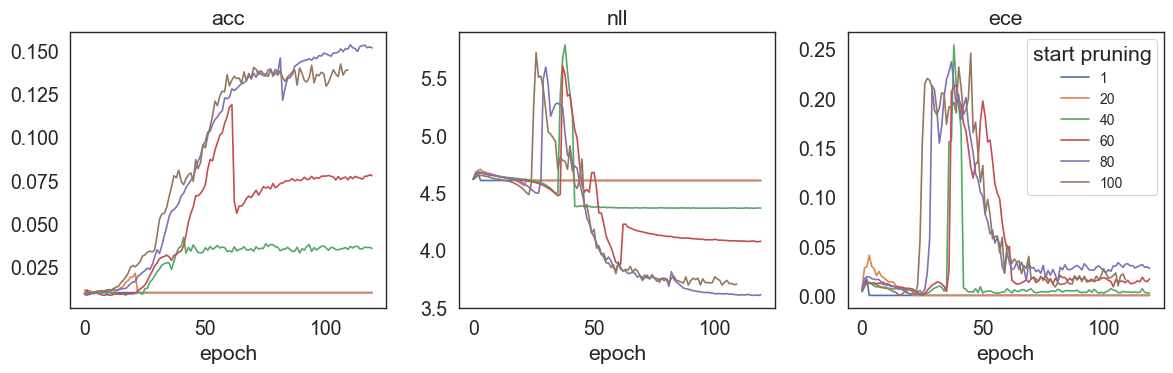

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, name in enumerate(['acc', 'nll', 'ece']):
    for j, sp in enumerate([1, 20, 40, 60, 80]):
        axes[i].plot(results_prune_cif100[j][name], label=sp)

    axes[i].plot(results_cif100[-1][name][:110], label=100)
    axes[i].set_title(name)
    axes[i].set_xlabel('epoch')

plt.legend(title='start pruning', fontsize=10)
fig.tight_layout()